In [1]:
%load_ext autoreload
%autoreload 2

import os, json, pickle
import nibabel as nb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import hrf_estimation
import scipy.signal as signal
import scipy.stats as stats
import scipy.ndimage as ndimage

from joblib import Parallel, delayed

import nideconv as nd
import scipy.io as io

%matplotlib inline

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


## Parameters and settings

In [2]:
# base_dir = "/Users/raimondo/Documents/Python Scripts/20190402/"
base_dir = "/scratch/2019/visual/line/GELINE_EXPISI_pilot/2020_02_14/"

# "runs_nodrift20200214.mat"
TR = 0.105
deleted_first_timepoints = 38
initial_deleted_time = TR * deleted_first_timepoints

# Sample rate and desired cutoff frequencies (in Hz).
fs = 1/TR

hp=0.01
lp=8.0
butter_order = 3 

## Behavioral 



In [3]:
pckl_list = [os.path.join(base_dir, 'task', 'luisa_1_2020-02-14_18.19.27_outputDict.pickle'),
             os.path.join(base_dir, 'task', 'luisa_2_2020-02-14_18.28.32_outputDict.pickle'),
             os.path.join(base_dir, 'task', 'luisa_3_2020-02-14_18.37.54_outputDict.pickle'),
             os.path.join(base_dir, 'task', 'luisa_4_2020-02-14_18.46.57_outputDict.pickle')
            ]

# load the data from pickles as an event Array
pckl_events = []
for p in pckl_list:
    with open(p, 'rb') as f:
        pckl_data = pickle.load(f, encoding='latin1')
        pckl_events.append(pckl_data['eventArray'])

# just printing an example to make sure it worked
print(pckl_events[0][0]) #primo numero e' il file (0,1,2,3), secondo numero e' l'n-esimo blocco nelle parentesi quadre, e terzo numero e' l-elemento in quel blocco
#print(pckl_events[2][0][1]) #file 3, blocco 1, elemento 2

['trial 0 started at 0.908483028412', [0, 40.81301212310791], 'trial 0 phase 1 started at 41.7214980125', 'trial 0 event t at 41.721503973', 'trial 0 phase 2 started at 59.721214056', 'trial 0 phase 3 started at 60.4712259769']


In [4]:
def relevant_times(pcl_events, opfn=None):
    start_time = float(pcl_events[0][2].split('trial 0 phase 1 started at ')[-1])
    
    ops = np.array([[],[],[]])
    for tr in pcl_events:
      # select only those with 't'rial start, i.e. type string
      sel_tr = [t for t in tr if type(t)==str]
      # select only those with 'phase' in there
      sel_tr = [t for t in sel_tr if 'phase' in t]
      tr_nrs = [int(t.split(' ')[1]) for t in sel_tr]
      tr_ph_nrs = [int(t.split(' ')[3]) for t in sel_tr]
      tr_times = [float(t.split(' ')[-1])-start_time for t in sel_tr] 
      ops = np.hstack((ops, np.array([tr_nrs, tr_ph_nrs, tr_times])))
    
    opd_df = pd.DataFrame(ops.T, 
                columns=['trial', 'trial_phase', 'time'])
    if opfn != None:
      opd_df.to_csv(opfn, sep='\t')
    
    return opd_df
  

In [5]:
#  get times per run, and save them out to .tsv file for future reference.
run_times = [relevant_times(pcl_events=p, opfn=os.path.join(base_dir, 'run_%i.txt'%i)) for i, p in enumerate(pckl_events)]
# the second trial phase time is the stimulus onset times. 
stim_times = [np.array(rt[rt.trial_phase==2].time) - initial_deleted_time for rt in run_times]

## Timeseries "preprocessing"

This amounts to high-pass filtering

In [6]:
def _butter_lowpass(data, highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='lowpass')
    y = signal.filtfilt(b, a, data)
    return y

def _butter_highpass(data, lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='highpass')
    y = signal.filtfilt(b, a, data)
    return y

def _butter_bandpass(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    data_hp = _butter_highpass(data, lowcut, fs, order)
    b, a = signal.butter(order, high, btype='lowpass')
    y = signal.filtfilt(b, a, data_hp)
    return y

In [7]:
ts_mat = io.loadmat(os.path.join(base_dir, 'runs_nodrift20200214.mat'))
run_data_complex = [ts_mat[f'run{i}'] for i in range(1,5)]
run_data_magnitude = [np.abs(ts_mat[f'run{i}']) for i in range(1,5)]

# cut off nothingness at the end
corrected_run_data = []
for i, rd in enumerate(run_data_magnitude):
    corrected_run_data.append(rd[:,:int(np.round(stim_times[i][-1] * fs))])

In [8]:
# just doing z-scoring now.
z_run_data = [(rd-rd.mean(-1)[:,np.newaxis]) / rd.std(1)[:,np.newaxis] for rd in corrected_run_data]

# or percent signal change?
z_run_data = [100*(rd-rd.mean(-1)[:,np.newaxis]) / rd.mean(1)[:,np.newaxis] for rd in corrected_run_data]

In [9]:
vox_cols = [f'vox {x}' for x in range(z_run_data[i].shape[0])]

mixed_data = pd.concat([pd.DataFrame(z_run_data[i].T, 
                    index=pd.MultiIndex.from_product(
                        [[i+1], 
                        list(TR*np.arange(z_run_data[i].shape[-1]))], names=['run', 't']
                   ), 
                    columns=vox_cols) for i in range(len(z_run_data))])
mixed_data.head()

vox 0      vox 1      vox 2      vox 3      vox 4       vox 5  \
run t                                                                          
1   0.000   3.633712 -31.266394  33.721058  15.155233 -73.572769  -10.962729   
    0.105  21.111450 -23.632521  -3.007014  -5.218302  18.151672   32.267670   
    0.210 -35.794193 -17.310534  27.239899 -23.645603 -25.691282  150.579941   
    0.315   8.350980 -26.485790 -69.056038   5.006250   3.675740  -11.114583   
    0.420   2.434543   6.287323 -70.873611 -46.951839 -61.267235  -63.753452   

               vox 6      vox 7      vox 8      vox 9  ...    vox 710  \
run t                                                  ...              
1   0.000  96.271576 -40.558041   3.874259 -44.508415  ... -19.958426   
    0.105  12.216895  13.147772  15.728566  24.567362  ...  27.721733   
    0.210 -28.793314   4.418539 -24.741501 -26.579952  ...  76.374969   
    0.315 -38.993999 -57.841736  -3.804709  65.575127  ... -21.049669   
    0.420  37.658279  -3.330391   4.331780 -25.742214  ... -16.521572   

             vox 711    vox 712    vox 713    vox 714    vox 715    vox 716  \
run t                                                                         
1   0.000  19.835129 -78.410316 -51.556915 -10.733925  27.395895  18.041346   
    0.105 -77.293297 -62.968430  19.252947  -0.560473  13.462303  -4.984537   
    0.210 -13.269857  15.950963 -61.165997  77.839966 -46.970299 -13.991928   
    0.315 -55.072937 -54.015949 -44.704834   5.487788 -41.256081  96.398224   
    0.420  67.588730 -41.979240 -10.614003 -36.687153 -22.442856  20.793327   

              vox 717    vox 718    vox 719  
run t                                        
1   0.000   10.595042 -67.278702 -83.210365  
    0.105  -48.829601 -35.192287  67.729027  
    0.210  -75.621559  68.691933  51.316391  
    0.315    9.945902 -46.338852 -42.706158  
    0.420  115.266205   0.166944 -14.690773  

[5 rows x 720 columns]

In [15]:
physio_cols = [f'card_{i}' for i in range(1,7)] + [f'resp_{i}' for i in range(1,9)] + [f'card_resp_int_{i}' for i in range(1,5)]

physio_data_list = [pd.read_csv(os.path.join(base_dir, f'run{f+1}.txt'), sep='\t') for f in range(len(z_run_data))]

mixed_physio_data = pd.concat([pd.DataFrame(physio_data_list[i].T, 
                    index=pd.MultiIndex.from_product(
                        [[i+1], 
                        list(TR*np.arange(z_run_data[i].shape[-1]))], names=['run', 't']
                   ), 
                    columns=physio_cols) for i in range(len(z_run_data))])
mixed_physio_data.head()

['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'r_1', 'r_2', 'r_3', 'r_4', 'r_5', 'r_6', 'r_7', 'r_8', 'cri_1', 'cri_2', 'cri_3', 'cri_4']


vox 0      vox 1      vox 2      vox 3      vox 4       vox 5  \
run t                                                                          
1   0.000   3.633712 -31.266394  33.721058  15.155233 -73.572769  -10.962729   
    0.105  21.111450 -23.632521  -3.007014  -5.218302  18.151672   32.267670   
    0.210 -35.794193 -17.310534  27.239899 -23.645603 -25.691282  150.579941   
    0.315   8.350980 -26.485790 -69.056038   5.006250   3.675740  -11.114583   
    0.420   2.434543   6.287323 -70.873611 -46.951839 -61.267235  -63.753452   

               vox 6      vox 7      vox 8      vox 9  ...    vox 710  \
run t                                                  ...              
1   0.000  96.271576 -40.558041   3.874259 -44.508415  ... -19.958426   
    0.105  12.216895  13.147772  15.728566  24.567362  ...  27.721733   
    0.210 -28.793314   4.418539 -24.741501 -26.579952  ...  76.374969   
    0.315 -38.993999 -57.841736  -3.804709  65.575127  ... -21.049669   
    0.420  37.658279  -3.330391   4.331780 -25.742214  ... -16.521572   

             vox 711    vox 712    vox 713    vox 714    vox 715    vox 716  \
run t                                                                         
1   0.000  19.835129 -78.410316 -51.556915 -10.733925  27.395895  18.041346   
    0.105 -77.293297 -62.968430  19.252947  -0.560473  13.462303  -4.984537   
    0.210 -13.269857  15.950963 -61.165997  77.839966 -46.970299 -13.991928   
    0.315 -55.072937 -54.015949 -44.704834   5.487788 -41.256081  96.398224   
    0.420  67.588730 -41.979240 -10.614003 -36.687153 -22.442856  20.793327   

              vox 717    vox 718    vox 719  
run t                                        
1   0.000   10.595042 -67.278702 -83.210365  
    0.105  -48.829601 -35.192287  67.729027  
    0.210  -75.621559  68.691933  51.316391  
    0.315    9.945902 -46.338852 -42.706158  
    0.420  115.266205   0.166944 -14.690773  

[5 rows x 720 columns]

### Title 
#### Subtitle
Some text here, and an equation:
$x = x^2$

![](https://www.researchgate.net/profile/Ar_Wallace/publication/229002387/figure/fig2/AS:648584164810752@1531645923539/Types-of-impulse-response-functions-a-instantaneous-b-memory-causal-c-premonition.png)

Let's try to add some physio to the deconv

In [10]:
mixed_onsets = pd.concat([pd.DataFrame(stim_times[i], columns=['onset']) for i in np.arange(len(stim_times))], keys=np.arange(len(stim_times))+1, names=['run'])
mixed_onsets.head()

onset
run             
1   0  14.009716
    1  23.259953
    2  34.526814
    3  47.510446
    4  53.210556

In [11]:
g_model = nd.GroupResponseFitter(mixed_data,
                              mixed_onsets,
                              input_sample_rate=1.0/TR,
                              concatenate_runs=True,
                              oversample_design_matrix=1,
                              confounds=mixed_physio_data)

In [14]:
g_model.onsets.head()


level_1      onset
subject run event_type                    
1       1   intercept         0  14.009716
            intercept         1  23.259953
            intercept         2  34.526814
            intercept         3  47.510446
            intercept         4  53.210556

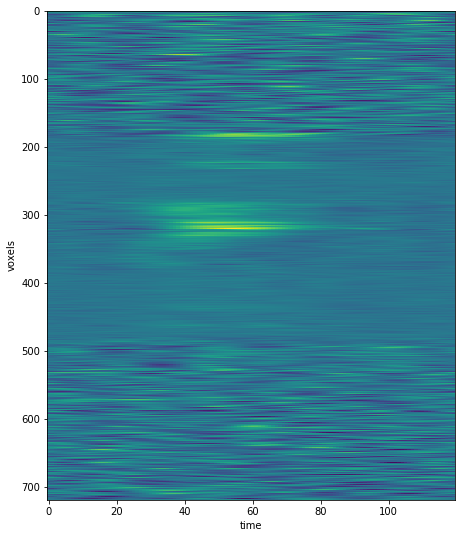

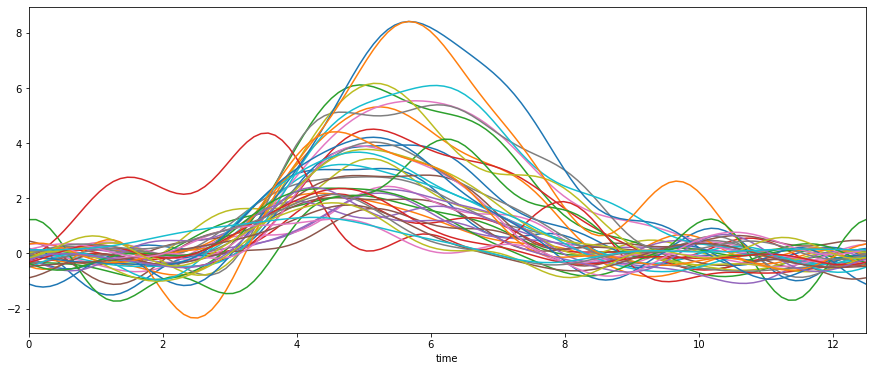

In [11]:
g_model.add_event(basis_set='fourier',
                  n_regressors=13,
                  interval=[0, 120*TR])

g_model.fit()

plt.figure(figsize=(24,9))
plt.imshow(g_model.get_conditionwise_timecourses().T, aspect=1/5) # , clim=[-0.01,0.01]
plt.gca().set_xlabel('time')
plt.gca().set_ylabel('voxels')

f = plt.figure(figsize=(15,6))
step = 0
for x in np.arange(300,340,1):
    g_model.get_conditionwise_timecourses().iloc[:, x].droplevel([0, 1]).plot(fig=f)

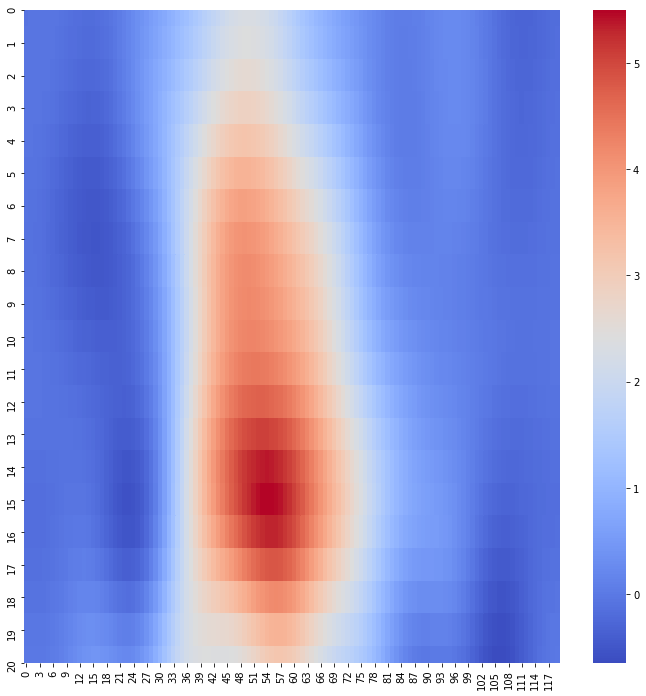

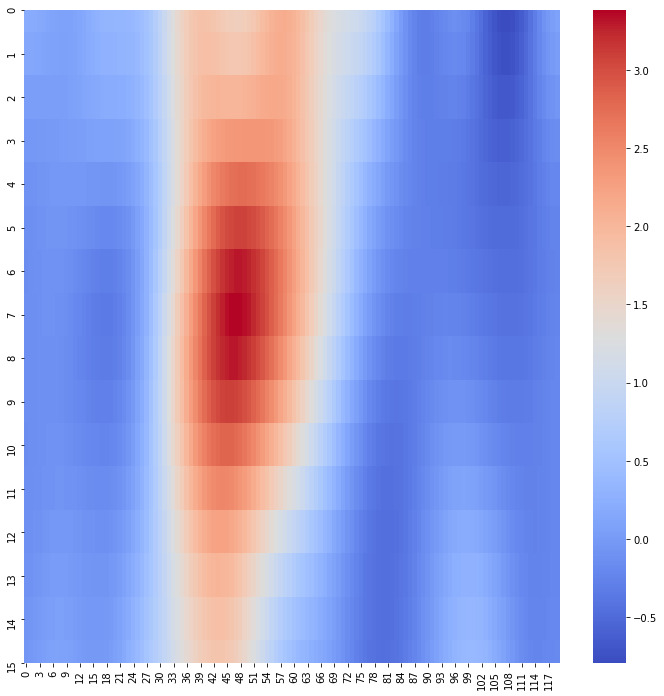

In [12]:
f = plt.figure(figsize=(12,12))
sns.heatmap(ndimage.filters.gaussian_filter(g_model.get_conditionwise_timecourses().iloc[:,304:325].T, 2.5), cmap='coolwarm')
f = plt.figure(figsize=(12,12))
sns.heatmap(ndimage.filters.gaussian_filter(g_model.get_conditionwise_timecourses().iloc[:,322:338].T, 2.5), cmap='coolwarm')